In [1]:
# 2D Toy training example
# Goal: examine how the gradients change the center and sigma of a single neuron
# Conclusions: Center Gradients are correct (moves to the right center)
# Further questions: What's going on with sigma?

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

# graph viz tool
# import sys
# sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research')
import torch_helper_lib as th

/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
torch.manual_seed(6656)
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [6]:
# Define 2d Toy Data

# number of dimensions of the data
num_dim = 2

# gaussian target parameters
bias = 1
data_centers = 1*np.ones(num_dim)
sigma = 1

# hyper-plane separating the classes (this will become the target for the weights)
sep_plane = np.random.uniform(low=-1.0, high=1.0, size=num_dim)
# sep_plane = np.concatenate(([1],np.zeros(num_dim-1)))

num_samples = 500

samples_xs = np.array([np.random.normal(loc=0, scale=sigma, size=num_dim)+data_centers for _ in range(num_samples)] )

# apply labels based on side of sep hyper plane
samples_labels = np.array([ [1] if x>np.matmul(data_centers, sep_plane) else [-1] for x in np.matmul(samples_xs, sep_plane)])

<IPython.core.display.Javascript object>


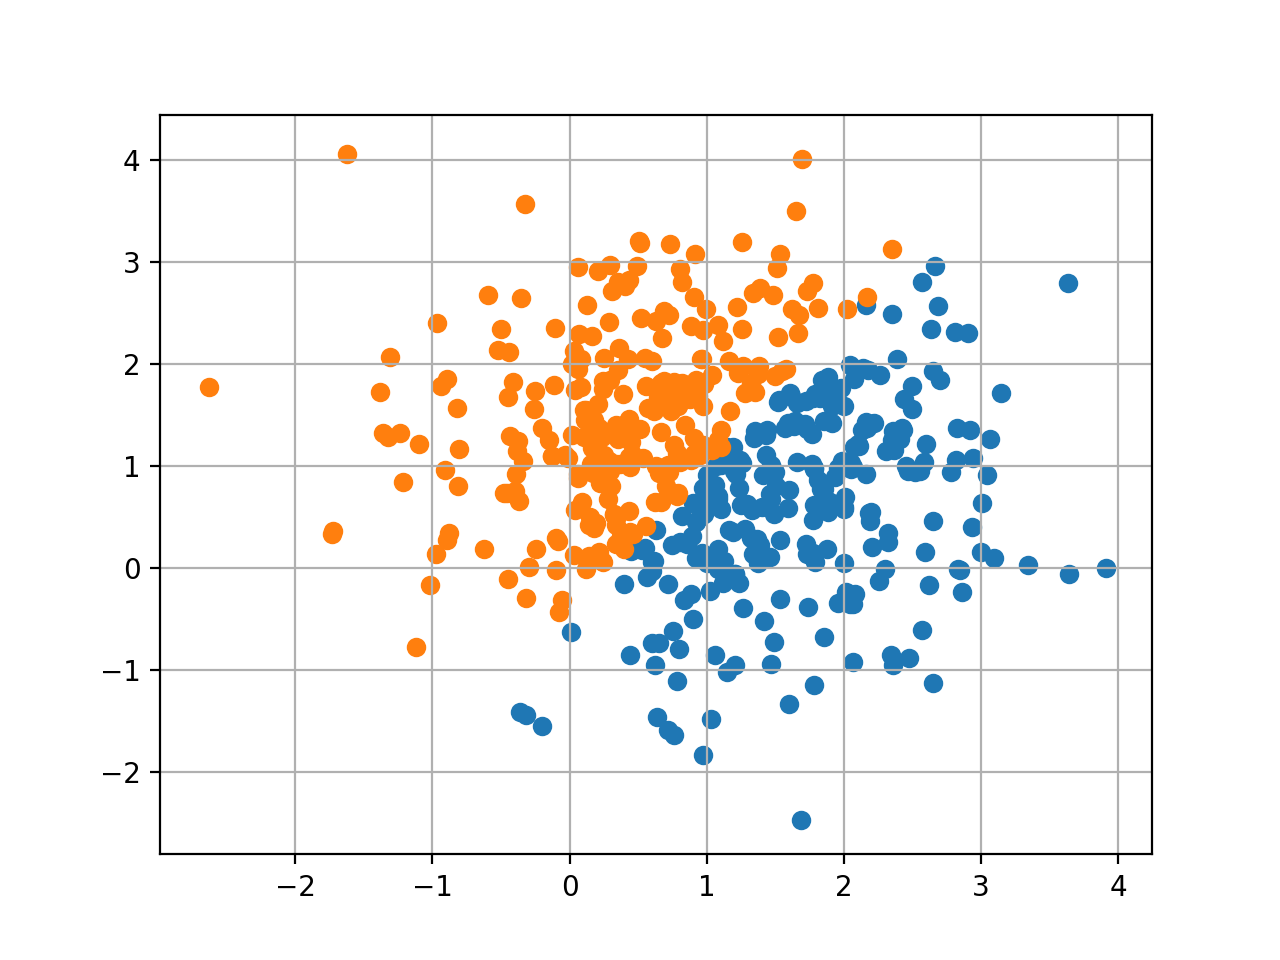

In [7]:
# 2D Check 
samples_x_1 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==1]
samples_y_1 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==1]

samples_x_2 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==-1]
samples_y_2 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==-1]


plt.scatter(samples_x_1, samples_y_1)
plt.scatter(samples_x_2, samples_y_2)
plt.grid(True)
plt.show()

In [8]:
# convert data to pytorch format 
tensor_x = torch.Tensor(samples_xs)
tensor_y = torch.Tensor(samples_labels)
# tensor_x = torch.stack([torch.Tensor(i) for i in zip(samples_x, samples_y)]) # transform to torch tensors
# tensor_y = torch.stack([torch.Tensor(i) for i in samples_labels])

my_dataset = torch.utils.data.TensorDataset(tensor_x[:num_samples*4/5],tensor_y[:num_samples*4/5]) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_x[num_samples*4/5:],tensor_y[num_samples*4/5:]) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=256) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data) # create your dataloader

In [9]:
# define the FGN layer class

###
# HARDCODED to be off center but not too far
### 

import math 

class FGN_layer(nn.Module):
    r""" Applies a Finite Gaussian Neuron layer to the incoming data
    
    Args:
    
    Shape:
    
    Attributes:
    
    Examples:
        
        >>> l=FGN_layer(20,30)
    
    """
    def __init__(self, in_features, out_features):
        super(FGN_layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # learnable parameters
        # regular NN weights (transposed at the start, see order of Tensor(dims))
        self.weights = nn.Parameter(torch.Tensor(out_features, in_features), requires_grad= True)
        # centers of FGNs
        self.centers = nn.Parameter(torch.Tensor(out_features, in_features), requires_grad = True)
        # size of FGNs
        self.sigs = nn.Parameter(torch.Tensor(out_features,), requires_grad = True)
        
        # parameter init call
        self.reset_parameters()
    
    # parameter init definition
    def reset_parameters(self):
        s = np.sqrt(self.in_features)
        # regular NN init
        self.weights.data.uniform_(-s, s)
        # centers init
        self.centers.data.uniform_(-0, -0)
        # size init
        self.sigs.data.uniform_(self.in_features, self.in_features)
        
    def forward(self, input):
        
        # linear part is the same as normal NNs
        l = nn.functional.linear(input, self.weights, bias=None)
        # optional, apply tanh here
        # l = torch.tanh(l)
#         print("size of L", l.size())
#         print(l)


        # gaussian component
        # unsqueeze the inputs to allow broadcasting
        # compute distance to centers
        g = (input.unsqueeze(1)-self.centers)**2
#         print("size of G", g.size())
        # print(g)
        g = g.sum(dim=2)
#         print("size of G", g.size())

        # for future, use any norm?
#         g = torch.norm(input.unsqueeze(1)-self.centers, p=1, dim=2)

        # apply sigma
        g = -g/(self.sigs**2)
#         print("size of G", g.size())
        # apply exponential
        g = torch.exp(g)
#         print("size of G", g.size())

        # combine gaussian with linear
        res = l*g
        # optional, flatten res
        # res = F.tanh(res)
#         print("size of L*G", res.size())

        # clip res to +1
        res  = torch.clamp(res, min=-1.0, max=1.0)
        
        
        return res
    

In [10]:
# Define a Finite Gaussian Neural Network

class FGNet(nn.Module):
    def __init__(self):
        super(FGNet, self).__init__()
        self.l1 = FGN_layer(2,1)

    def forward(self, x):
        # input: tensor of ... batch? sample?
        x = self.l1(x)
#         x = x.view(1)

        return x

In [11]:
# Initialize the network
model = FGNet().to(device)

In [12]:
# model stats
print(model)
print([p.size() for p in list(model.parameters())])
print("Training?", model.training) 

# check sizes
print("l1")
print(model.l1.weights.size()) 
print(model.l1.centers.size()) 
print(model.l1.sigs.size())

# check weights before training
print("l1")
print(model.l1.weights.view(-1).cpu().detach().numpy()[0:4])
print(model.l1.centers.view(-1).cpu().detach().numpy()[0:4])
print(model.l1.sigs.view(-1).cpu().detach().numpy()[0:4])

FGNet(
  (l1): FGN_layer()
)
[torch.Size([1, 2]), torch.Size([1, 2]), torch.Size([1])]
Training? True
l1
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1])
l1
[-0.11149967  1.3149358 ]
[0. 0.]
[2.]


In [13]:
def train(model, device, train_loader, optimizer, epoch):
    
    # values to return
    weights =  []
    centers = []
    sigmas = []
    weights.append(list(model.l1.weights.view(-1).cpu().detach().numpy()))
    centers.append(list(model.l1.centers.view(-1).cpu().detach().numpy()))
    sigmas.append(list(model.l1.sigs.view(-1).cpu().detach().numpy()))
    
    losses = th.AverageMeter()
    correct = 0
    
    # set model to trainable mode
    model.train()
    # load a batch
    for batch_idx, (data, target) in enumerate(train_loader):
#         print(data,target)
        # load batch data, targets to device
        data, target = data.to(device), target.to(device)
        # reset optimizer gradients
        optimizer.zero_grad()
        # compute predictions
        output = model(data)
#         print(output)
        # compute loss
        loss = F.mse_loss(output, target.float())
        # print(loss)
        
        # update rolling average loss
        losses.update(loss.item(), data.size(0) )
        # update predictions
        pred = torch.Tensor.sign(output)
        correct += pred.eq(target.view_as(pred)).sum().item()        
        
        # propagate gradients
        loss.backward()
#         print("max grad centers:", torch.max(model.l1.centers.grad) )
#         print("max grad sigs:", torch.max(model.l1.sigs.grad) )

        # apply stored gradients to parameters
        optimizer.step()
        
        # print batch stats
#         if batch_idx % (num_samples/5) == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
#             print("batch:", batch_idx, " Loss", losses.avg)
    
        weights.append(list(model.l1.weights.view(-1).cpu().detach().numpy()))
        centers.append(list(model.l1.centers.view(-1).cpu().detach().numpy()))
        sigmas.append(list(model.l1.sigs.view(-1).cpu().detach().numpy()))
        
        
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        losses.avg, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

    return(weights, centers, sigmas)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, target.float())
            pred = torch.Tensor.sign(output)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [14]:
# train the model 

optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.5, weight_decay=0.01)

# values to observes
weights_per_update =  []
centers_per_update = []
sigmas_per_update = []

In [15]:
for epoch in range(1, 500):
    print("Epoch:", epoch)
    weights, centers, sigmas = train(model, device, my_dataloader, optimizer, epoch)
    weights_per_update+=weights
    centers_per_update+=centers
    sigmas_per_update+=sigmas
    
    test(model, device, my_test_dataloader)

Epoch: 1
Train set: Average loss: 1.9596, Accuracy: 147/400 (37%)
Test set: Average loss: 1.9419, Accuracy: 32/100 (32%)
Epoch: 2
Train set: Average loss: 1.9209, Accuracy: 147/400 (37%)
Test set: Average loss: 1.8812, Accuracy: 32/100 (32%)
Epoch: 3
Train set: Average loss: 1.8618, Accuracy: 148/400 (37%)
Test set: Average loss: 1.8080, Accuracy: 33/100 (33%)
Epoch: 4
Train set: Average loss: 1.7860, Accuracy: 149/400 (37%)
Test set: Average loss: 1.7339, Accuracy: 34/100 (34%)
Epoch: 5
Train set: Average loss: 1.7097, Accuracy: 150/400 (38%)
Test set: Average loss: 1.6668, Accuracy: 34/100 (34%)
Epoch: 6
Train set: Average loss: 1.6411, Accuracy: 150/400 (38%)
Test set: Average loss: 1.6075, Accuracy: 34/100 (34%)
Epoch: 7
Train set: Average loss: 1.5809, Accuracy: 153/400 (38%)
Test set: Average loss: 1.5555, Accuracy: 34/100 (34%)
Epoch: 8
Train set: Average loss: 1.5283, Accuracy: 153/400 (38%)
Test set: Average loss: 1.5097, Accuracy: 35/100 (35%)
Epoch: 9
Train set: Average loss

Test set: Average loss: 1.0141, Accuracy: 49/100 (49%)
Epoch: 81
Train set: Average loss: 1.0093, Accuracy: 193/400 (48%)
Test set: Average loss: 1.0132, Accuracy: 49/100 (49%)
Epoch: 82
Train set: Average loss: 1.0084, Accuracy: 194/400 (48%)
Test set: Average loss: 1.0124, Accuracy: 50/100 (50%)
Epoch: 83
Train set: Average loss: 1.0076, Accuracy: 194/400 (48%)
Test set: Average loss: 1.0115, Accuracy: 50/100 (50%)
Epoch: 84
Train set: Average loss: 1.0068, Accuracy: 195/400 (49%)
Test set: Average loss: 1.0106, Accuracy: 50/100 (50%)
Epoch: 85
Train set: Average loss: 1.0061, Accuracy: 195/400 (49%)
Test set: Average loss: 1.0098, Accuracy: 50/100 (50%)
Epoch: 86
Train set: Average loss: 1.0053, Accuracy: 195/400 (49%)
Test set: Average loss: 1.0090, Accuracy: 50/100 (50%)
Epoch: 87
Train set: Average loss: 1.0045, Accuracy: 196/400 (49%)
Test set: Average loss: 1.0081, Accuracy: 50/100 (50%)
Epoch: 88
Train set: Average loss: 1.0038, Accuracy: 196/400 (49%)
Test set: Average loss: 

Test set: Average loss: 0.9428, Accuracy: 57/100 (57%)
Epoch: 152
Train set: Average loss: 0.9415, Accuracy: 227/400 (57%)
Test set: Average loss: 0.9411, Accuracy: 57/100 (57%)
Epoch: 153
Train set: Average loss: 0.9398, Accuracy: 227/400 (57%)
Test set: Average loss: 0.9393, Accuracy: 57/100 (57%)
Epoch: 154
Train set: Average loss: 0.9381, Accuracy: 227/400 (57%)
Test set: Average loss: 0.9375, Accuracy: 57/100 (57%)
Epoch: 155
Train set: Average loss: 0.9363, Accuracy: 228/400 (57%)
Test set: Average loss: 0.9356, Accuracy: 57/100 (57%)
Epoch: 156
Train set: Average loss: 0.9345, Accuracy: 228/400 (57%)
Test set: Average loss: 0.9337, Accuracy: 57/100 (57%)
Epoch: 157
Train set: Average loss: 0.9327, Accuracy: 229/400 (57%)
Test set: Average loss: 0.9318, Accuracy: 57/100 (57%)
Epoch: 158
Train set: Average loss: 0.9308, Accuracy: 230/400 (58%)
Test set: Average loss: 0.9298, Accuracy: 57/100 (57%)
Epoch: 159
Train set: Average loss: 0.9289, Accuracy: 232/400 (58%)
Test set: Averag

Test set: Average loss: 0.6912, Accuracy: 74/100 (74%)
Epoch: 224
Train set: Average loss: 0.6842, Accuracy: 304/400 (76%)
Test set: Average loss: 0.6862, Accuracy: 74/100 (74%)
Epoch: 225
Train set: Average loss: 0.6788, Accuracy: 304/400 (76%)
Test set: Average loss: 0.6811, Accuracy: 74/100 (74%)
Epoch: 226
Train set: Average loss: 0.6735, Accuracy: 304/400 (76%)
Test set: Average loss: 0.6760, Accuracy: 74/100 (74%)
Epoch: 227
Train set: Average loss: 0.6680, Accuracy: 306/400 (76%)
Test set: Average loss: 0.6708, Accuracy: 74/100 (74%)
Epoch: 228
Train set: Average loss: 0.6625, Accuracy: 308/400 (77%)
Test set: Average loss: 0.6656, Accuracy: 74/100 (74%)
Epoch: 229
Train set: Average loss: 0.6570, Accuracy: 308/400 (77%)
Test set: Average loss: 0.6604, Accuracy: 74/100 (74%)
Epoch: 230
Train set: Average loss: 0.6514, Accuracy: 312/400 (78%)
Test set: Average loss: 0.6551, Accuracy: 75/100 (75%)
Epoch: 231
Train set: Average loss: 0.6458, Accuracy: 314/400 (78%)
Test set: Averag

Train set: Average loss: 0.2994, Accuracy: 381/400 (95%)
Test set: Average loss: 0.3085, Accuracy: 94/100 (94%)
Epoch: 299
Train set: Average loss: 0.2970, Accuracy: 381/400 (95%)
Test set: Average loss: 0.3060, Accuracy: 95/100 (95%)
Epoch: 300
Train set: Average loss: 0.2947, Accuracy: 381/400 (95%)
Test set: Average loss: 0.3035, Accuracy: 95/100 (95%)
Epoch: 301
Train set: Average loss: 0.2925, Accuracy: 381/400 (95%)
Test set: Average loss: 0.3010, Accuracy: 95/100 (95%)
Epoch: 302
Train set: Average loss: 0.2903, Accuracy: 381/400 (95%)
Test set: Average loss: 0.2987, Accuracy: 95/100 (95%)
Epoch: 303
Train set: Average loss: 0.2882, Accuracy: 381/400 (95%)
Test set: Average loss: 0.2964, Accuracy: 95/100 (95%)
Epoch: 304
Train set: Average loss: 0.2862, Accuracy: 383/400 (96%)
Test set: Average loss: 0.2942, Accuracy: 95/100 (95%)
Epoch: 305
Train set: Average loss: 0.2842, Accuracy: 383/400 (96%)
Test set: Average loss: 0.2920, Accuracy: 96/100 (96%)
Epoch: 306
Train set: Avera

Test set: Average loss: 0.2200, Accuracy: 96/100 (96%)
Epoch: 373
Train set: Average loss: 0.2177, Accuracy: 383/400 (96%)
Test set: Average loss: 0.2194, Accuracy: 96/100 (96%)
Epoch: 374
Train set: Average loss: 0.2172, Accuracy: 383/400 (96%)
Test set: Average loss: 0.2189, Accuracy: 96/100 (96%)
Epoch: 375
Train set: Average loss: 0.2167, Accuracy: 383/400 (96%)
Test set: Average loss: 0.2184, Accuracy: 96/100 (96%)
Epoch: 376
Train set: Average loss: 0.2162, Accuracy: 383/400 (96%)
Test set: Average loss: 0.2179, Accuracy: 96/100 (96%)
Epoch: 377
Train set: Average loss: 0.2157, Accuracy: 383/400 (96%)
Test set: Average loss: 0.2174, Accuracy: 96/100 (96%)
Epoch: 378
Train set: Average loss: 0.2152, Accuracy: 383/400 (96%)
Test set: Average loss: 0.2169, Accuracy: 96/100 (96%)
Epoch: 379
Train set: Average loss: 0.2147, Accuracy: 383/400 (96%)
Test set: Average loss: 0.2164, Accuracy: 96/100 (96%)
Epoch: 380
Train set: Average loss: 0.2143, Accuracy: 383/400 (96%)
Test set: Averag

Test set: Average loss: 0.1940, Accuracy: 96/100 (96%)
Epoch: 452
Train set: Average loss: 0.1913, Accuracy: 383/400 (96%)
Test set: Average loss: 0.1938, Accuracy: 96/100 (96%)
Epoch: 453
Train set: Average loss: 0.1910, Accuracy: 383/400 (96%)
Test set: Average loss: 0.1936, Accuracy: 96/100 (96%)
Epoch: 454
Train set: Average loss: 0.1908, Accuracy: 383/400 (96%)
Test set: Average loss: 0.1934, Accuracy: 96/100 (96%)
Epoch: 455
Train set: Average loss: 0.1906, Accuracy: 383/400 (96%)
Test set: Average loss: 0.1932, Accuracy: 96/100 (96%)
Epoch: 456
Train set: Average loss: 0.1903, Accuracy: 383/400 (96%)
Test set: Average loss: 0.1930, Accuracy: 96/100 (96%)
Epoch: 457
Train set: Average loss: 0.1901, Accuracy: 383/400 (96%)
Test set: Average loss: 0.1928, Accuracy: 96/100 (96%)
Epoch: 458
Train set: Average loss: 0.1899, Accuracy: 383/400 (96%)
Test set: Average loss: 0.1926, Accuracy: 96/100 (96%)
Epoch: 459
Train set: Average loss: 0.1897, Accuracy: 383/400 (96%)
Test set: Averag

In [16]:
# check weights after training
print("l1")
print(model.l1.weights.view(-1).cpu().detach().numpy()[0:4])
print(model.l1.centers.view(-1).cpu().detach().numpy()[0:4])
print(model.l1.sigs.view(-1).cpu().detach().numpy()[0:4])

l1
[ 1.568215  -1.4005735]
[0.72612447 0.5483235 ]
[2.6288707]


In [17]:
# l1
# [-0.53201663 -0.65015894]
# [-1. -1.]
# [2.]

<IPython.core.display.Javascript object>


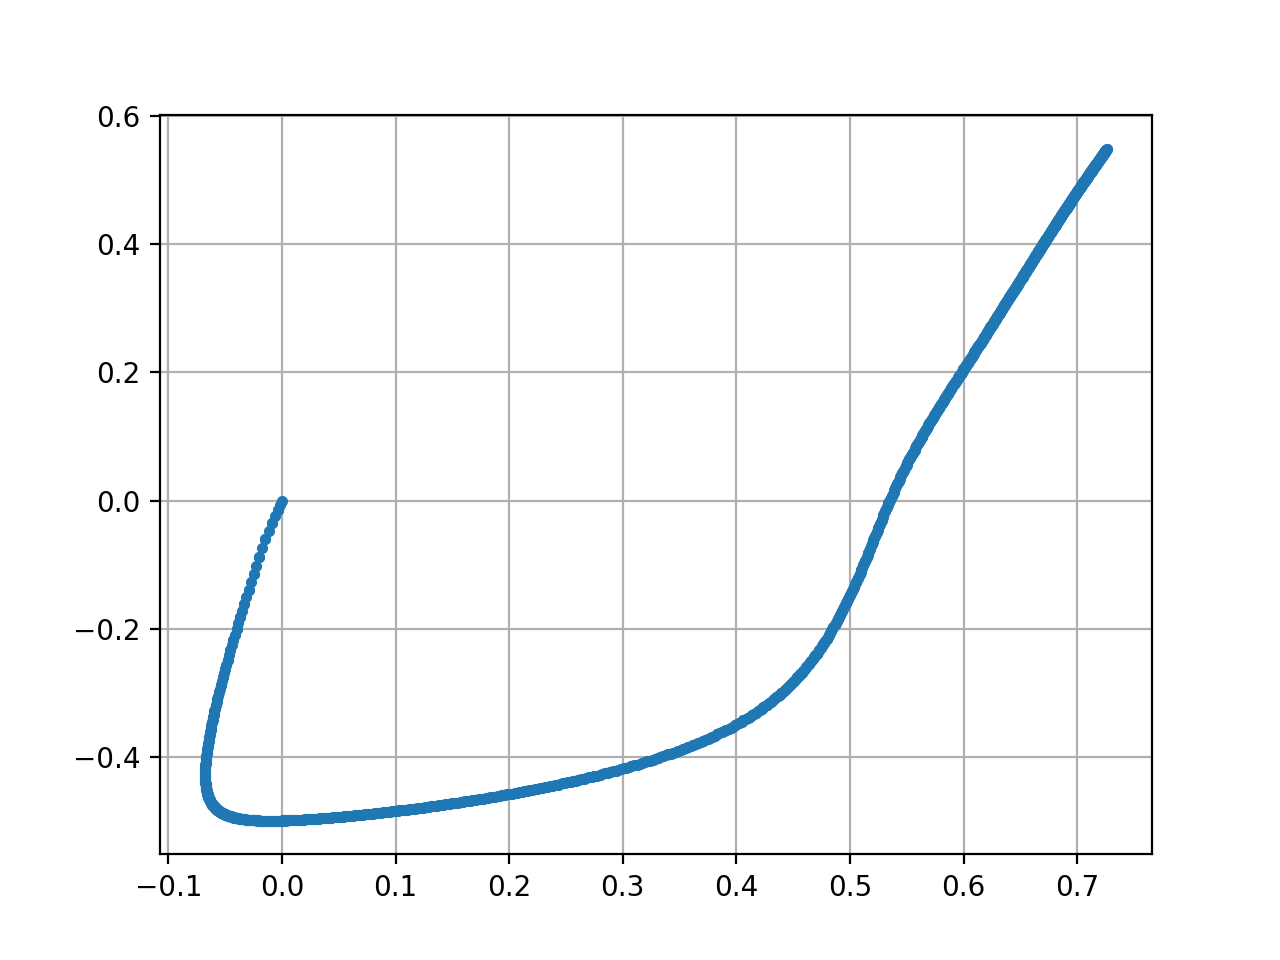

In [18]:
x, y = zip(*centers_per_update)
plt.plot(x,y, marker='.', linestyle=' ')
# plt.axis([-3,3, -3, 3])
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


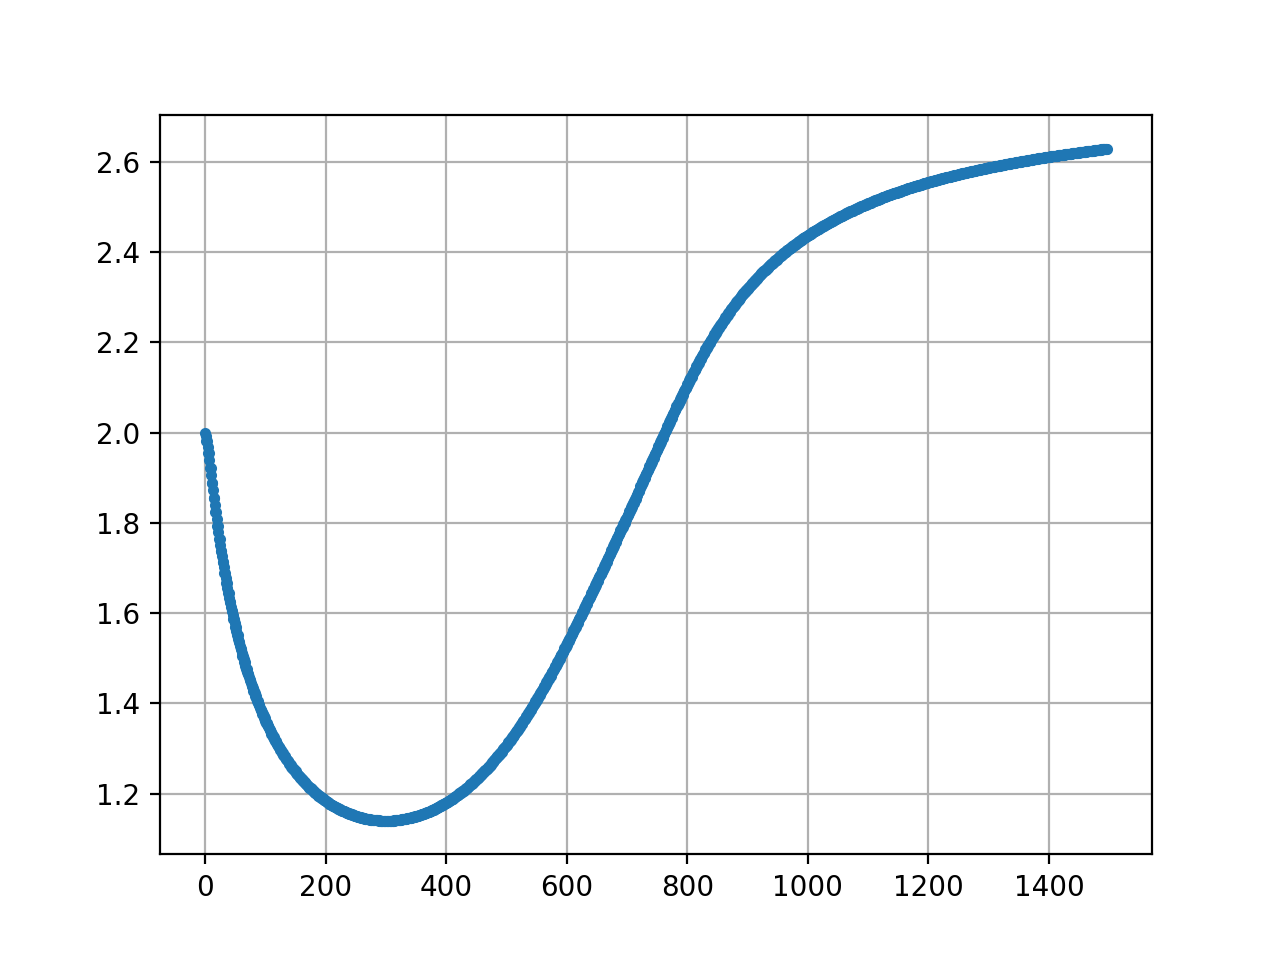

In [19]:
plt.plot(sigmas_per_update, marker='.', linestyle=' ')
plt.grid()
plt.show()